In [47]:
# Install PyTorch and PyTorch Geometric
!pip install torch torchvision

import torch
print(f"PyTorch has version {torch.__version__}")

# Install PyTorch Geometric and its dependencies
# Adjust the TORCH and CUDA versions according to the output from torch.__version__ and torch.version.cuda
TORCH_VERSION = torch.__version__.split('+')[0]
CUDA_VERSION = torch.version.cuda.replace('.', '')

# Install torch-scatter, torch-sparse, torch-cluster, torch-spline-conv, and torch-geometric
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+cu{CUDA_VERSION}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+cu{CUDA_VERSION}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+cu{CUDA_VERSION}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH_VERSION}+cu{CUDA_VERSION}.html
!pip install torch-geometric


PyTorch has version 2.5.1+cu121
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html


In [48]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, SAGEConv, GATConv
from torch_geometric.utils import train_test_split_edges, negative_sampling
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import roc_auc_score, average_precision_score
import random
import numpy as np
from itertools import product


In [49]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)


In [50]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]


In [51]:
print(f'Dataset: {dataset}')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')

print('\nData details:')
print('======================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Training nodes: {data.train_mask.sum()}')
print(f'Validation nodes: {data.val_mask.sum()}')
print(f'Test nodes: {data.test_mask.sum()}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data details:
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Training nodes: 140
Validation nodes: 500
Test nodes: 1000
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


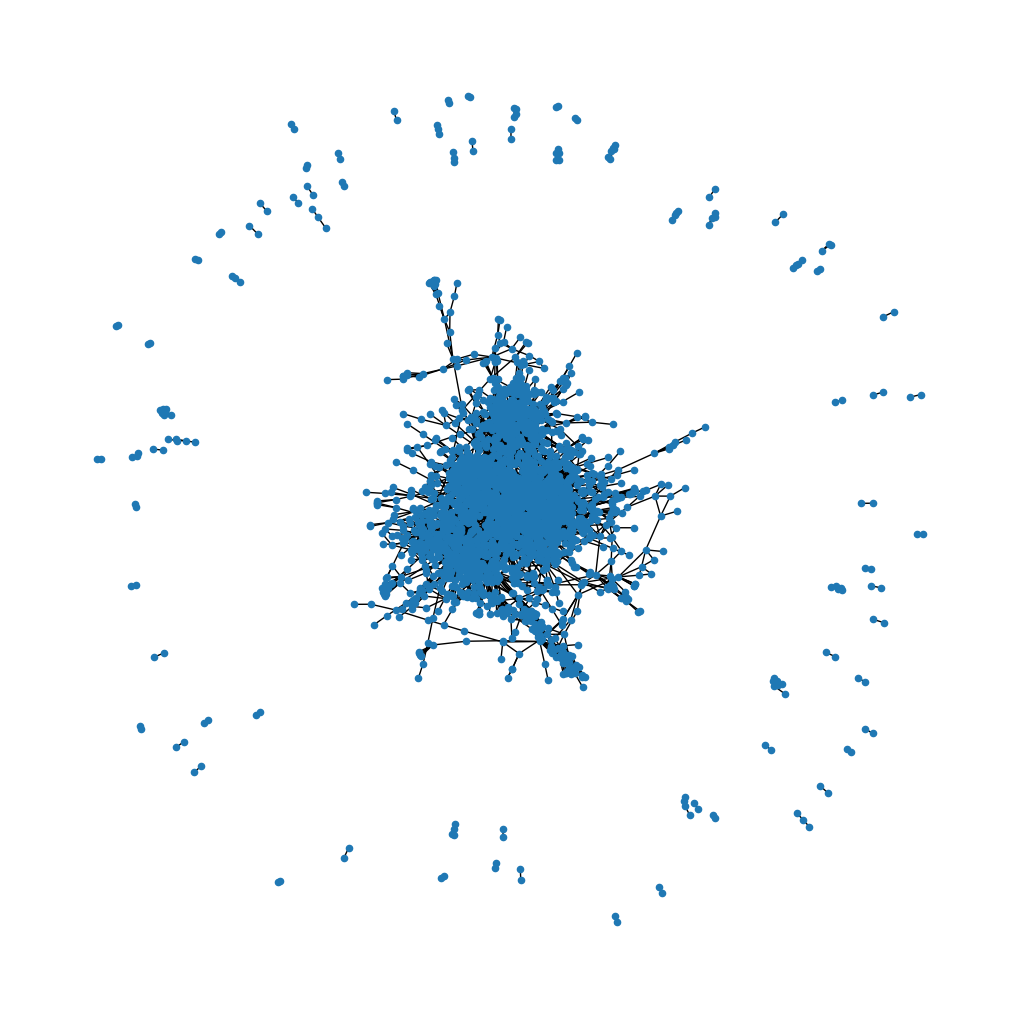

In [52]:
edge_index = data.edge_index
G = nx.Graph()
edges = edge_index.t().tolist()
G.add_edges_from(edges)

plt.figure(figsize=(10, 10))
nx.draw(G, node_size=20)
plt.show()


In [53]:
data = train_test_split_edges(data)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [54]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, dropout=0.5):
        super(GCNEncoder, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GCNConv(in_channels, hidden_channels, improved=True))
        for _ in range(num_layers - 1):
            self.convs.append(GCNConv(hidden_channels, hidden_channels, improved=True))
        self.dropout = dropout

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x


In [55]:
class GraphSAGEEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, dropout=0.5):
        super(GraphSAGEEncoder, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.dropout = dropout

    def forward(self, x, edge_index):
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        return x


In [56]:
class GATEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, heads=8, dropout=0.6):
        super(GATEncoder, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout))
        for _ in range(num_layers - 1):
            self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout))
        self.dropout = dropout
        self.heads = heads

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]:
            x = conv(x, edge_index)
            x = F.elu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, edge_index)
        return x


In [57]:
class LinkPredictor(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers, encoder_class=GCNEncoder, **encoder_kwargs):
        super(LinkPredictor, self).__init__()
        self.encoder = encoder_class(dataset.num_node_features, hidden_channels, num_layers, **encoder_kwargs)

    def decode(self, z, edge_index):
        # Dot product decoding
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)

    def forward(self, x, edge_index, pos_edge_index, neg_edge_index):
        z = self.encoder(x, edge_index)
        pos_logits = self.decode(z, pos_edge_index)
        neg_logits = self.decode(z, neg_edge_index)
        logits = torch.cat([pos_logits, neg_logits], dim=0)
        pos_labels = torch.ones(pos_edge_index.size(1), device=x.device)
        neg_labels = torch.zeros(neg_edge_index.size(1), device=x.device)
        labels = torch.cat([pos_labels, neg_labels], dim=0)
        return logits, labels


In [58]:
def train():
    model.train()
    optimizer.zero_grad()
    # Sample negative edges
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1),
    )
    logits, labels = model(data.x, data.train_pos_edge_index, data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(logits, labels)
    loss.backward()
    optimizer.step()
    return loss.item()


In [59]:
@torch.no_grad()
def test(pos_edge_index, neg_edge_index):
    model.eval()
    z = model.encoder(data.x, data.train_pos_edge_index)
    pos_logits = model.decode(z, pos_edge_index)
    neg_logits = model.decode(z, neg_edge_index)
    logits = torch.cat([pos_logits, neg_logits], dim=0)
    labels = torch.cat([
        torch.ones(pos_logits.size(0), device=device),
        torch.zeros(neg_logits.size(0), device=device)
    ])
    pred = logits.sigmoid()
    auc = roc_auc_score(labels.cpu(), pred.cpu())
    ap = average_precision_score(labels.cpu(), pred.cpu())
    return auc, ap


In [60]:
def train_and_evaluate(encoder_class, encoder_name, **kwargs):
    print(f'\nTraining with {encoder_name}')
    model = LinkPredictor(hidden_channels=kwargs['hidden_dim'], num_layers=kwargs['num_layers'], encoder_class=encoder_class, dropout=kwargs.get('dropout', 0.5)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['lr'], weight_decay=kwargs.get('weight_decay', 1e-4))

    best_val_auc = 0
    best_model_state = None
    for epoch in range(1, 51):
        loss = train()
        val_auc, val_ap = test(data.val_pos_edge_index, data.val_neg_edge_index)
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model_state = model.state_dict()
        if epoch % 10 == 0:
            print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}')

    model.load_state_dict(best_model_state)
    test_auc, test_ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print(f'{encoder_name} Test AUC: {test_auc:.4f}, Test AP: {test_ap:.4f}')
    return model, test_auc, test_ap


In [61]:
learning_rates = [0.01, 0.005, 0.001]
hidden_dims = [32, 64, 128]
num_layers_options = [2, 3]


In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

best_overall_auc = 0
best_overall_model = None
best_hyperparams = {}
encoder_class = GCNEncoder
encoder_name = 'GCN'

for lr, hidden_dim, num_layers in product(learning_rates, hidden_dims, num_layers_options):
    print(f'\nTraining with lr={lr}, hidden_dim={hidden_dim}, num_layers={num_layers}')
    model = LinkPredictor(hidden_dim, num_layers, encoder_class=encoder_class, dropout=0.5).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    best_val_auc = 0
    best_model_state = None
    for epoch in range(1, 51):
        loss = train()
        val_auc, val_ap = test(data.val_pos_edge_index, data.val_neg_edge_index)
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_model_state = model.state_dict()
        if epoch % 10 == 0:
            print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}')

    model.load_state_dict(best_model_state)
    test_auc, test_ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print(f'Validation AUC: {best_val_auc:.4f}, Test AUC: {test_auc:.4f}, Test AP: {test_ap:.4f}')

    if test_auc > best_overall_auc:
        best_overall_auc = test_auc
        best_overall_model = model
        best_hyperparams = {'lr': lr, 'hidden_dim': hidden_dim, 'num_layers': num_layers}



Training with lr=0.01, hidden_dim=32, num_layers=2
Epoch 010, Loss: 0.5689, Val AUC: 0.8162, Val AP: 0.8078
Epoch 020, Loss: 0.4891, Val AUC: 0.8609, Val AP: 0.8726
Epoch 030, Loss: 0.4656, Val AUC: 0.8936, Val AP: 0.9023
Epoch 040, Loss: 0.4513, Val AUC: 0.9007, Val AP: 0.9118
Epoch 050, Loss: 0.4476, Val AUC: 0.9063, Val AP: 0.9197
Validation AUC: 0.9063, Test AUC: 0.9070, Test AP: 0.9113

Training with lr=0.01, hidden_dim=32, num_layers=3
Epoch 010, Loss: 0.6464, Val AUC: 0.7334, Val AP: 0.7379
Epoch 020, Loss: 0.5299, Val AUC: 0.8317, Val AP: 0.8160
Epoch 030, Loss: 0.5150, Val AUC: 0.8827, Val AP: 0.8844
Epoch 040, Loss: 0.4876, Val AUC: 0.8858, Val AP: 0.8943
Epoch 050, Loss: 0.4867, Val AUC: 0.8835, Val AP: 0.8903
Validation AUC: 0.8886, Test AUC: 0.8951, Test AP: 0.8998

Training with lr=0.01, hidden_dim=64, num_layers=2
Epoch 010, Loss: 0.6497, Val AUC: 0.7387, Val AP: 0.7659
Epoch 020, Loss: 0.5626, Val AUC: 0.8417, Val AP: 0.8358
Epoch 030, Loss: 0.4896, Val AUC: 0.8671, Va

In [63]:
print(f'\nBest Hyperparameters: {best_hyperparams}')
print(f'Best Test AUC: {best_overall_auc:.4f}')



Best Hyperparameters: {'lr': 0.001, 'hidden_dim': 128, 'num_layers': 2}
Best Test AUC: 0.9370


In [64]:
encoders = [
    (GCNEncoder, 'GCN', {'dropout': 0.5}),
    (GraphSAGEEncoder, 'GraphSAGE', {'dropout': 0.5}),
    (GATEncoder, 'GAT', {'dropout': 0.6, 'heads': 8}),
]


In [65]:
results = {}
for encoder_class, encoder_name, encoder_kwargs in encoders:
    model, test_auc, test_ap = train_and_evaluate(
        encoder_class,
        encoder_name,
        lr=best_hyperparams['lr'],
        hidden_dim=best_hyperparams['hidden_dim'],
        num_layers=best_hyperparams['num_layers'],
        **encoder_kwargs
    )
    results[encoder_name] = {'Test AUC': test_auc, 'Test AP': test_ap}



Training with GCN
Epoch 010, Loss: 0.4158, Val AUC: 0.9348, Val AP: 0.9410
Epoch 020, Loss: 0.4196, Val AUC: 0.9374, Val AP: 0.9432
Epoch 030, Loss: 0.4139, Val AUC: 0.9371, Val AP: 0.9434
Epoch 040, Loss: 0.4144, Val AUC: 0.9355, Val AP: 0.9422
Epoch 050, Loss: 0.4090, Val AUC: 0.9320, Val AP: 0.9409
GCN Test AUC: 0.9268, Test AP: 0.9324

Training with GraphSAGE
Epoch 010, Loss: 0.6463, Val AUC: 0.7514, Val AP: 0.7496
Epoch 020, Loss: 0.6461, Val AUC: 0.7514, Val AP: 0.7496
Epoch 030, Loss: 0.6461, Val AUC: 0.7514, Val AP: 0.7496
Epoch 040, Loss: 0.6458, Val AUC: 0.7514, Val AP: 0.7496
Epoch 050, Loss: 0.6453, Val AUC: 0.7514, Val AP: 0.7496
GraphSAGE Test AUC: 0.7394, Test AP: 0.7423

Training with GAT
Epoch 010, Loss: 0.7041, Val AUC: 0.5053, Val AP: 0.5109
Epoch 020, Loss: 0.7027, Val AUC: 0.5053, Val AP: 0.5109
Epoch 030, Loss: 0.7027, Val AUC: 0.5053, Val AP: 0.5109
Epoch 040, Loss: 0.7003, Val AUC: 0.5053, Val AP: 0.5109
Epoch 050, Loss: 0.7024, Val AUC: 0.5053, Val AP: 0.5109


In [66]:
print('\nResults Summary:')
for model_name, metrics in results.items():
    print(f"{model_name}: Test AUC = {metrics['Test AUC']:.4f}, Test AP = {metrics['Test AP']:.4f}")



Results Summary:
GCN: Test AUC = 0.9268, Test AP = 0.9324
GraphSAGE: Test AUC = 0.7394, Test AP = 0.7423
GAT: Test AUC = 0.5803, Test AP = 0.5754


In [67]:
@torch.no_grad()
def visualize_predictions(model, data, model_name):
    model.eval()
    z = model.encoder(data.x, data.train_pos_edge_index)
    edge_index = torch.cat([data.test_pos_edge_index, data.test_neg_edge_index], dim=-1)
    logits = model.decode(z, edge_index)
    probs = logits.sigmoid()
    K = 50
    _, indices = torch.topk(probs, K)
    top_edge_index = edge_index[:, indices]

    G_pred = nx.Graph()
    G_pred.add_edges_from(top_edge_index.cpu().numpy().T)

    plt.figure(figsize=(10, 10))
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, node_size=20, node_color='blue', alpha=0.6)
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    nx.draw_networkx_edges(G_pred, pos, edge_color='red', width=2)
    plt.title(f'Graph with Top Predicted Links by {model_name} (in red)')
    plt.show()



Visualizing predictions for best model: GCN


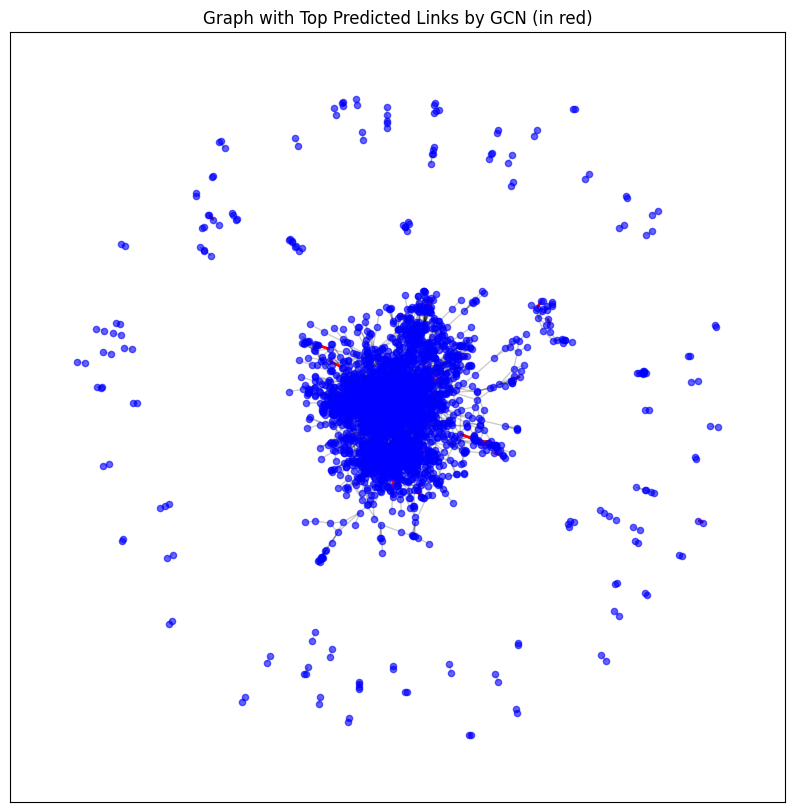

In [68]:
best_model_name = max(results, key=lambda k: results[k]['Test AUC'])
print(f'\nVisualizing predictions for best model: {best_model_name}')

best_model = model  # Use the model from the last iteration in the loop

visualize_predictions(best_model, data, best_model_name)


In [69]:
torch.save(best_model.state_dict(), 'best_link_prediction_model.pth')
print("Best model saved to 'best_link_prediction_model.pth'")


Best model saved to 'best_link_prediction_model.pth'
